In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio import plot, mask
from rasterstats import zonal_stats
import xarray
import numpy as np
from dateutil import parser
import os

# Import polygons

These are preselected landslide polygons from Tanyas 2022

In [23]:
# import landslide polygons
shapefile_shx = "../0-brute-raw-data/Landslides.shx"
nz_landslide_polygons = gpd.read_file(shapefile_shx)
nz_landslide_polygons

,OBJECTID,LD,Shape_Leng,Shape_Area,area,xLoc,yLoc,geometry
0,1,1,6294.572688,971012.709717,971012.709717,None,None,"POLYGON ((224168.801 5319214.443, 224176.674 5..."
1,2,0,534.474179,6510.391251,6510.391251,None,None,"POLYGON ((224135.776 5318458.596, 224137.014 5..."
2,3,0,1600.066686,46399.058635,46399.058635,None,None,"POLYGON ((223868.599 5318137.775, 223855.370 5..."
3,4,0,1645.958267,34457.252781,34457.252781,None,None,"POLYGON ((224014.114 5317351.976, 224004.037 5..."
4,5,0,316.753483,4571.300600,4571.300600,None,None,"POLYGON ((224074.165 5317697.594, 224088.204 5..."
...,...,...,...,...,...,...,...,...
14228,14230,1,719.732270,24666.229609,24666.229609,None,None,"POLYGON ((234482.468 5349619.469, 234485.797 5..."
14229,14231,0,787.175176,24079.652938,24079.652938,None,None,"POLYGON ((194301.472 5289968.004, 194311.884 5..."
14230,14232,1,1009.043796,43493.688376,43493.688376,None,None,"POLYGON ((194361.309 5290054.116, 194360.043 5..."
14231,14233,0,1046.510759,25285.918579,25285.918579,None,None,"POLYGON ((230603.338 5345977.410, 230596.440 5..."


In [3]:
%matplotlib inline

<Axes: >

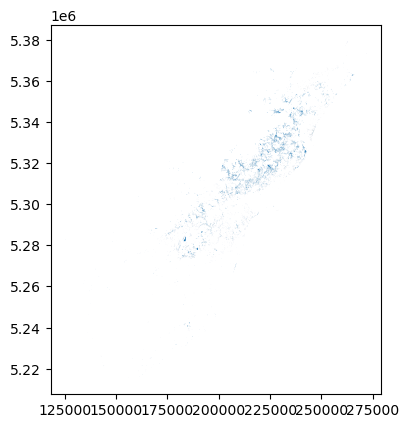

In [4]:
nz_landslide_polygons.plot()

# Match crs

The polygons are in UTM zone 60S, but we want them in the same CRS as the raster data. I'm choosing to reproject the polygons because the raster is already in the roughly-equal-area transverse mercator format and warping will introduce potential errors

In [5]:
img_folder = "../1-raw-data/ndvi/"

test_fn = "LC08_L2SP_073089_20161215_20200905_02_T1_ndvi"

test_src = rio.open(img_folder + test_fn+".TIF")
ndvi_crs = test_src.crs
ndvi_crs

CRS.from_epsg(32659)

Text(0.5, 1.0, 'NDVI, 15/12/2016')

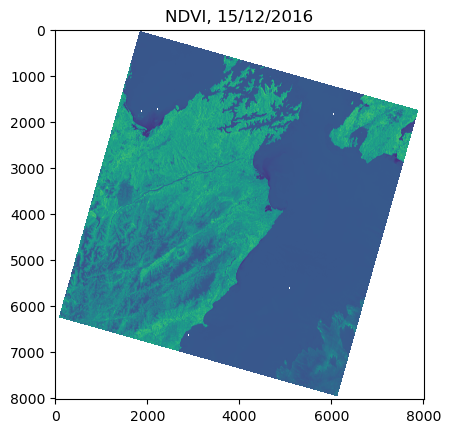

In [6]:
plt.imshow(test_src.read(1, masked=True))
plt.title("NDVI, 15/12/2016")

In [7]:
nz_landslide_polygons.crs

<Projected CRS: EPSG:32760>
Name: WGS 84 / UTM zone 60S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 174°E and 180°E, southern hemisphere between 80°S and equator, onshore and offshore. New Zealand.
- bounds: (174.0, -80.0, 180.0, 0.0)
Coordinate Operation:
- name: UTM zone 60S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
nz_landslide_reprojected = nz_landslide_polygons.to_crs(ndvi_crs)
nz_landslide_reprojected.crs

<Projected CRS: EPSG:32659>
Name: WGS 84 / UTM zone 59N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 59N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Plot data and polygons

For now, only considering one tile of landsat data for time/memory. Could bring in another one for future investigation (just tweak the download code with a new bounding box).

In [24]:
r= test_src.read(1, masked = True)

<Axes: >

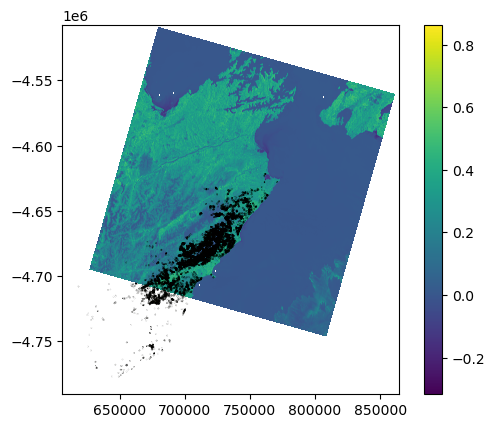

In [10]:
ndvi_extent = rio.plot.plotting_extent(test_src)

f, ax = plt.subplots()
a = ax.imshow(r, extent=ndvi_extent)
f.colorbar(a)
nz_landslide_reprojected.plot(ax=ax, facecolor='y', edgecolor='k')

In [11]:
test_src.nodata

999.9000244140625

# Find NDVI statistics for each polygon and then save to CSV format

In [12]:
rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
nz_ma, nz_ma_transform = rio.mask.mask(test_src, nz_landslide_reprojected.geometry, **rio_mask_kwargs)
nz_ma_extent = rio.plot.plotting_extent(nz_ma, nz_ma_transform)

In [13]:
mean_above_zero = lambda l: l[l>0].mean()
count_above_zero = lambda l: np.count_nonzero(l[l>0])


In [14]:
stats = ['count', 'mean']
zonalstats = zonal_stats(nz_landslide_reprojected, raster=r, affine=test_src.transform,nodata=test_src.nodata,
            stats=stats)
zonalstats


[{'mean': 0.028924401364805088, 'count': 1076},
 {'mean': 0.03191793816430228, 'count': 7},
 {'mean': 0.0334006431056004, 'count': 51},
 {'mean': 0.1073705742998821, 'count': 41},
 {'mean': 0.1257871389389038, 'count': 4},
 {'mean': 0.09082699815432231, 'count': 6},
 {'mean': 0.14493286609649658, 'count': 8},
 {'mean': 0.15114925305048624, 'count': 12},
 {'mean': 0.11552965256475634, 'count': 31},
 {'mean': 0.1398301883177324, 'count': 11},
 {'mean': 0.094236026207606, 'count': 12},
 {'mean': 0.13039355278015136, 'count': 5},
 {'mean': 0.11062486171722412, 'count': 15},
 {'mean': 0.13769592344760895, 'count': 8},
 {'mean': 0.2845979928970337, 'count': 3},
 {'mean': 0.17890357971191406, 'count': 6},
 {'mean': 0.1164931297302246, 'count': 5},
 {'mean': 0.23525230089823404, 'count': 9},
 {'mean': 0.23572885990142822, 'count': 3},
 {'mean': 0.24349982397896902, 'count': 14},
 {'mean': 0.13428982372941642, 'count': 29},
 {'mean': 0.13316144545873007, 'count': 6},
 {'mean': 0.112642201510342

In [15]:
nz_landslide_reprojected.head()

,OBJECTID,LD,Shape_Leng,Shape_Area,area,xLoc,yLoc,geometry
0,1,1,6294.572688,971012.709717,971012.709717,None,None,"POLYGON ((719299.877 -4678794.256, 719307.478 ..."
1,2,0,534.474179,6510.391251,6510.391251,None,None,"POLYGON ((719213.776 -4679545.646, 719214.183 ..."
2,3,0,1600.066686,46399.058635,46399.058635,None,None,"POLYGON ((718924.785 -4679846.765, 718916.619 ..."
3,4,0,1645.958267,34457.252781,34457.252781,None,None,"POLYGON ((719014.603 -4680640.581, 719006.256 ..."
4,5,0,316.753483,4571.300600,4571.300600,None,None,"POLYGON ((719098.802 -4680300.165, 719111.566 ..."


In [60]:
zonal_df.to_csv("../2-processed data/ndvi/" + test_fn + ".csv")

In [ ]:
%matplotlib widget

(-4680000.0, -4670000.0)

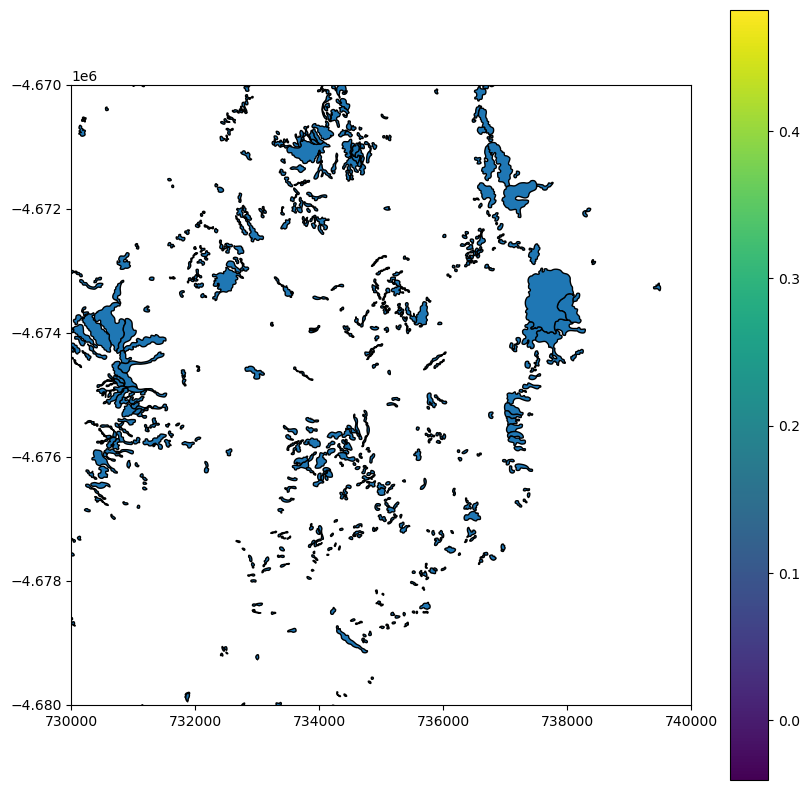

In [104]:
f, ax = plt.subplots(figsize=(10, 10))

nz_landslide_reprojected.plot('mean', legend=True, ax=ax)
nz_landslide_reprojected.plot(edgecolor='k', legend=True, ax=ax)

ax.set_xlim([730000,740000])
ax.set_ylim([-4.68e6, -4.67e6])


# Calculate stats for each time step

In [20]:
#Import image list

images = []

for input in ['img_list.txt', 'autoselected_images.txt']:
    with open(img_folder + input) as f:
        for l in f:
            id = l.split(',')[1]
            if os.path.exists(img_folder + id + "_ndvi.TIF"):
                images.append(id)
            elif os.path.exists(img_folder + id[:-1] + "_ndvi.TIF"):
                images.append(id[:-1])

images

['LC08_L2SP_073089_20161215_20200905_02_T1',
 'LC08_L2SP_073089_20160419_20200907_02_T1',
 'LC08_L2SP_073089_20161012_20200905_02_T1',
 'LC08_L2SP_073089_20161215_20200905_02_T1',
 'LC08_L2SP_073089_20171202_20200902_02_T1',
 'LC08_L2SP_073089_20181018_20200830_02_T1',
 'LC08_L2SP_073089_20201210_20210313_02_T1',
 'LC09_L2SP_073089_20221122_20230321_02_T1',
 'LC08_L2SP_073089_20231219_20240103_02_T1',
 'LE07_L2SP_074089_20231210_20240105_02_T1',
 'LC09_L2SP_073089_20231125_20231128_02_T1',
 'LC08_L2SP_073089_20221114_20221122_02_T1',
 'LC09_L2SP_073089_20221106_20221110_02_T1',
 'LE07_L2SP_073089_20221104_20221130_02_T1',
 'LE07_L2SP_073089_20201202_20201229_02_T1',
 'LE07_L2SP_073089_20201031_20201127_02_T1',
 'LC08_L2SP_073089_20201023_20201105_02_T1',
 'LE07_L2SP_073089_20201015_20201111_02_T1',
 'LC08_L2SP_073089_20191208_20200824_02_T1',
 'LC08_L2SP_073089_20191005_20200825_02_T1',
 'LE07_L2SP_073089_20181111_20200827_02_T1',
 'LC08_L2SP_073089_20181018_20200830_02_T1',
 'LE07_L2S

In [21]:
def clip_to_polygons(img, gpd):
    out_fn = "../2-processed data/ndvi/" + img + ".csv"
    if not os.path.exists(out_fn):
        src = rio.open(img_folder + img+"_ndvi.TIF")
        r = src.read(1, masked=True)
        zonalstats = zonal_stats(gpd, raster=r, affine=src.transform,nodata=src.nodata,
                stats=['count', 'mean'])
        zonal_df = pd.DataFrame(zonalstats, columns = ['count', 'mean'])
        zonal_df.to_csv("../2-processed data/ndvi/" + img + ".csv")

In [22]:
for img in images:
    print(img)
    clip_to_polygons(img, nz_landslide_reprojected)

LC08_L2SP_073089_20161215_20200905_02_T1
LC08_L2SP_073089_20160419_20200907_02_T1
LC08_L2SP_073089_20161012_20200905_02_T1
LC08_L2SP_073089_20161215_20200905_02_T1
LC08_L2SP_073089_20171202_20200902_02_T1
LC08_L2SP_073089_20181018_20200830_02_T1
LC08_L2SP_073089_20201210_20210313_02_T1
LC09_L2SP_073089_20221122_20230321_02_T1
LC08_L2SP_073089_20231219_20240103_02_T1
LE07_L2SP_074089_20231210_20240105_02_T1
LC09_L2SP_073089_20231125_20231128_02_T1
LC08_L2SP_073089_20221114_20221122_02_T1
LC09_L2SP_073089_20221106_20221110_02_T1
LE07_L2SP_073089_20221104_20221130_02_T1
LE07_L2SP_073089_20201202_20201229_02_T1
LE07_L2SP_073089_20201031_20201127_02_T1
LC08_L2SP_073089_20201023_20201105_02_T1
LE07_L2SP_073089_20201015_20201111_02_T1
LC08_L2SP_073089_20191208_20200824_02_T1
LC08_L2SP_073089_20191005_20200825_02_T1
LE07_L2SP_073089_20181111_20200827_02_T1
LC08_L2SP_073089_20181018_20200830_02_T1
LE07_L2SP_073089_20171210_20200830_02_T1
LC08_L2SP_073089_20171202_20200902_02_T1
LE07_L2SP_073089